In [28]:
import sys
import scipy
import pickle

from sklearn.neighbors import BallTree

from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


In [30]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [31]:
class setOfObjects(BallTree):    

    def __init__(self,data_points):     

        super(setOfObjects,self).__init__(data_points)

        self._n             =   len(self.data)
        self._processed     =   scipy.zeros((self._n,1),dtype=bool) ## Start all points as 'unprocessed' ##
        self._reachability  =   scipy.ones(self._n)*scipy.inf       ## Important! Do not change! ##
        self._core_dist     =   scipy.ones(self._n)*scipy.nan
        self._index         =   scipy.array(range(self._n))         ## Might be faster to use a list? ##
        self._nneighbors    =   scipy.ones(self._n,dtype=int)
        self._cluster_id    =   -scipy.ones(self._n,dtype=int)      ## Start all points as noise ##
        self._is_core       =   scipy.ones(self._n,dtype=bool)
        self._ordered_list  =   []                                  ### DO NOT switch this to a hash table, ordering is important ###
        
        ### so... top level object is OPTICS... which is the estimator
        ### OPTICS is called with a dataset, a min number of points per cluster, ### disregard
        ###        and an optional max-epsilon value that defaults to the range of the dataset ### disregard
        
        ### there is an object flag that sets whether a fit has been called? maybe...
        ### anyway, main call ( OPTICS.order(minpts, max_epsilon) ), returns a cluster ordered list or array,
        ### and modifies self--- probably better to both? I actually like just an object...
        
        
        
    ## Used in prep step ##
    def _set_neighborhood(self,point,epsilon):
        self._nneighbors[point] = self.query_radius(self.data[point], epsilon, count_only=1)[0]

    ## Used in prep step ##
    def _set_core_dist(self,point,MinPts):
        self._core_dist[point]  = self.query(self.data[point],MinPts)[0][0][-1]

#    def __iter__(self):  ## Could make tree itself iterable? ##
#        output = (self._index[n] for n in self._index if not self._processed[self._index[n]])


In [32]:
### Paralizeable! ###
def prep_optics(SetofObjects,epsilon,MinPts):
    for i in SetofObjects._index:
        SetofObjects._set_neighborhood(i,epsilon)
    for j in SetofObjects._index:
        if SetofObjects._nneighbors[j] >= MinPts:
            SetofObjects._set_core_dist(j,MinPts)
    print('Core distances and neighborhoods prepped for ' + str(SetofObjects._n) + ' points.')

In [33]:
def build_optics(SetOfObjects,epsilon,MinPts,Output_file_name):
    for point in SetOfObjects._index:
        if SetOfObjects._processed[point] == False:
            expandClusterOrder(SetOfObjects,point,epsilon,
                               MinPts,Output_file_name)
                               

In [34]:
### NOT Paralizeable! The order that entries are written to the '_ordered_list' is important! ###
def expandClusterOrder(SetOfObjects,point,epsilon,MinPts,Output_file_name):
    if SetOfObjects._core_dist[point] <= epsilon:
        while not SetOfObjects._processed[point]:
            SetOfObjects._processed[point] = True
            SetOfObjects._ordered_list.append(point)
            ## Comment following two lines to not write to a text file ##
            with open(Output_file_name, 'a') as file:
                file.write((str(point) + ', ' + str(SetOfObjects._reachability[point]) + '\n'))
                ## Keep following line! ##
                point = set_reach_dist(SetOfObjects,point,epsilon)
        print('Object Found!')
    else: 
        SetOfObjects._processed[point] = True    # Probably not needed... #


In [35]:
### As above, NOT paralizable! Paralizing would allow items in 'unprocessed' list to switch to 'processed' ###
def set_reach_dist(SetOfObjects,point_index,epsilon):

    ###  Assumes that the query returns ordered (smallest distance first) entries     ###
    ###  This is the case for the balltree query...                                   ###
    ###  ...switching to a query structure that does not do this will break things!   ###
    ###  And break in a non-obvious way: For cases where multiple entries are tied in ###
    ###  reachablitly distance, it will cause the next point to be processed in       ###
    ###  random order, instead of the closest point. This may manefest in edge cases  ###
    ###  where different runs of OPTICS will give different ordered lists and hence   ### 
    ###  different clustering structure...removing reproducability.                   ###
    
    distances, indices = SetOfObjects.query(SetOfObjects.data[point_index],
                                            SetOfObjects._nneighbors[point_index])
    
    ## Checks to see if there more than one member in the neighborhood ##
    if scipy.iterable(distances):

        ## Masking processed values ##
        unprocessed = indices[(SetOfObjects._processed[indices] < 1)[0].T]
        rdistances = scipy.maximum(distances[(SetOfObjects._processed[indices] < 1)[0].T],SetOfObjects._core_dist[point_index])
        SetOfObjects._reachability[unprocessed] = scipy.minimum(SetOfObjects._reachability[unprocessed], rdistances)

        ### Checks to see if everything is already processed; if so, return control to main loop ##
        if unprocessed.size > 0:            
            ### Define return order based on reachability distance ###
            return sorted(zip(SetOfObjects._reachability[unprocessed],unprocessed), key=lambda reachability: reachability[0])[0][1]
        else:
            return point_index
    else: ## Not sure if this else statement is actaully needed... ##
        return point_index

    

In [36]:
# Important: Epsilon prime should be less than epsilon used in OPTICS #
def ExtractDBSCAN(SetOfObjects, epsilon_prime):       
    # Start Cluster_id at zero, incremented to '1' for first cluster 
    cluster_id = 0                           
    for entry in SetOfObjects._ordered_list:
        if SetOfObjects._reachability[entry] > epsilon_prime:
            if SetOfObjects._core_dist[entry] <= epsilon_prime:
                cluster_id += 1
                SetOfObjects._cluster_id[entry] = cluster_id
                # Two gives first member of the cluster; not meaningful, as first cluster members do not correspond to centroids #
                ## SetOfObjects._is_core[entry] = 2     ## Breaks boolean array :-( ##
            else:
                # This is only needed for compatibility for repeated scans. -1 is Noise points #
                SetOfObjects._cluster_id[entry] = -1 
        else:
            SetOfObjects._cluster_id[entry] = cluster_id
            if SetOfObjects._core_dist[entry] <= epsilon_prime:
                # One (i.e., 'True') for core points #
                SetOfObjects._is_core[entry] = 1 
            else:
                # Zero (i.e., 'False') for non-core, non-noise points #
                SetOfObjects._is_core[entry] = 0 

In [37]:
##### End Algorithm #####

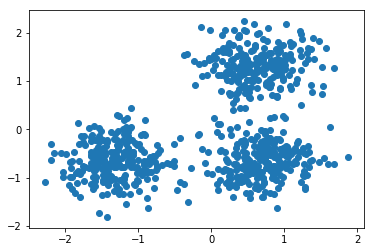

In [38]:
## Set up test data ##
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
import pylab as pl
pl.figure()
pl.scatter(X[:,0],X[:,1])
pl.show()


In [39]:
# Load the data into the classifier object
testtree = setOfObjects(X)

In [42]:
# Run the top-level optics algorithm

prep_optics(testtree,30,10)
# Note: build_optics should process using the same parameters as prep optics #
build_optics(testtree,30,10,'./testing_may6.txt')

# Note: Prep optics could be parellized. 
# build_optics currently writes to a text file in addition to the object; 
# this can be modified to fit the scikit-learn API

/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fe

Core distances and neighborhoods prepped for 750 points.


/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fe

In [25]:
# Extract clustering structure. This can be run for any clustering distance, and can be run mulitiple times without rerunning OPTICS
# OPTICS does need to be re-run to change the min-pts parameter
# Currently no load method to restore from text file
ExtractDBSCAN(testtree,0.2)

In [26]:
# Core samples and labels #
core_samples = testtree._index[testtree._is_core[:] > 0]
labels = testtree._cluster_id[:]
n_clusters_ = max(testtree._cluster_id)
len(testtree._index[testtree._is_core[:] > 0])

638

/Users/seanhendryx/anaconda/envs/OPTICS/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


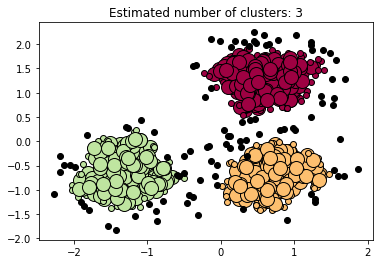

In [27]:
# Plot results #
import pylab as pl
import numpy as np

# Black removed and is used for noise instead.
unique_labels = set(testtree._cluster_id[:]) # modifed from orginal #
colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        markersize = 6
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    for index in class_members:
        x = X[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

pl.title('Estimated number of clusters: %d' % n_clusters_)
pl.show()

In [298]:
## Using a larger dataset ##

In [270]:
testdata = scipy.rand(5000,3)

In [271]:
test_set = setOfObjects(testdata)

In [272]:
prep_optics(test_set,30,5)
# Note: build_optics should process using the same parameters as prep optics #
build_optics(test_set,30,5,'./testing_may6.txt')

Core distances and neighborhoods prepped for 5000 points.
Object Found!


In [293]:
ExtractDBSCAN(test_set,0.069)

In [294]:
# Core samples and labels #
core_samples = test_set._index[test_set._is_core[:] == True]
labels = test_set._cluster_id[:]
n_clusters_ = max(test_set._cluster_id)
n_clusters_

8

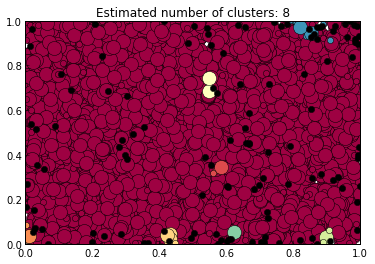

In [295]:
import pylab as pl

# Black removed and is used for noise instead.
unique_labels = set(test_set._cluster_id[:]) # modifed from orginal #
colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        markersize = 6
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    for index in class_members:
        x = test_set.data[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

pl.title('Estimated number of clusters: %d' % n_clusters_)
pl.show()